In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import random
import pulp

# Time Series Analysis of Energy Data

Prompt: "Make a dataset containing power output (in megawatts) from a solar farm recorded hourly over a month. Then write a Python script to analyze the time series data. Your script should identify the peak production hours and any anomalous dips in power generation. Also, include a brief explanation of how weather or other external factors might affect these readings."

Skills Tested: Data manipulation, time series analysis, basic understanding of renewable energy systems.

## Create sample data

In [3]:
sample_df = pd.DataFrame(pd.date_range(start='1/1/2023', end='1/31/2023 23:00', freq='H'), columns=['date'])
sample_df.set_index('date', inplace=True)

# Constants
DAYS = 31
HOURS_IN_DAY = 24
MEAN_SUNLIGHT_HOUR = 12  # Assuming peak sunlight at noon
STD_DEV = 3  # Standard deviation in hours, determines how "spread out" the sunlight hours are
SAMPLE_PEAK_POWER = 10 # in MW

power_output = []
for day in range(DAYS):
    # Create a daily profile centered around noon with 3 hours of spread:
    hours = np.arange(HOURS_IN_DAY)
    daily_power_output = norm.pdf(x=hours, loc=MEAN_SUNLIGHT_HOUR, scale=STD_DEV)
    daily_power_output = np.clip(daily_power_output, a_min=0, a_max=None) # Clip values less than 0
    # Normalize by the maximum, multiply by the sample peak power, then randomly multiply by a value between 0.8-1.1 for daily variety
    daily_power_output = daily_power_output / daily_power_output.max() * SAMPLE_PEAK_POWER * random.uniform(0.8,1.1)
    power_output.extend(daily_power_output)
    
sample_df["power_output"] = power_output

In [4]:
sample_df

,power_output
date,
2023-01-01 00:00:00,0.003683
2023-01-01 01:00:00,0.013218
2023-01-01 02:00:00,0.042448
2023-01-01 03:00:00,0.121977
2023-01-01 04:00:00,0.313651
...,...
2023-01-31 19:00:00,0.653699
2023-01-31 20:00:00,0.284096
2023-01-31 21:00:00,0.110484


<Axes: title={'center': 'Day 1 of Sample Power Data'}, xlabel='date'>

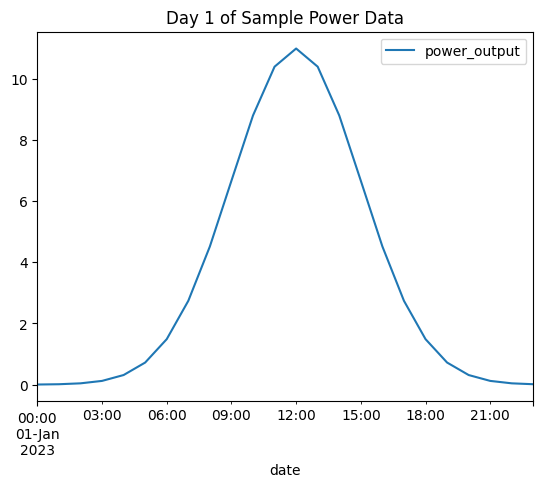

In [5]:
sample_df[0:24].plot(title="Day 1 of Sample Power Data")

<Axes: xlabel='date'>

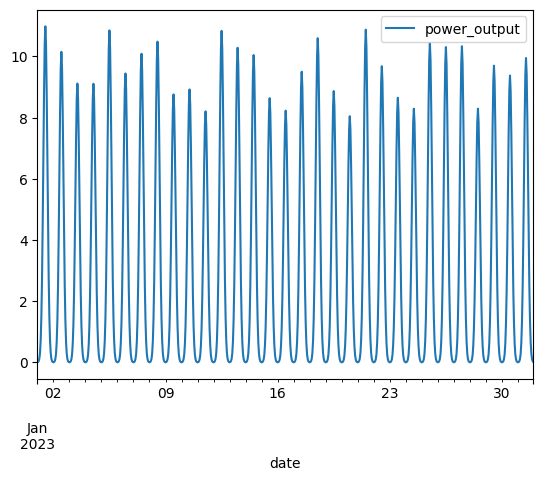

In [6]:
sample_df.plot()

## Identify the peak production hours and any anomalous dips in power generation

In [7]:
# Identify top 10 power output values
top_10_power = sample_df.sort_values(by="power_output", ascending=False)[0:10]
top_10_power

,power_output
date,
2023-01-01 12:00:00,10.980062
2023-01-21 12:00:00,10.869979
2023-01-05 12:00:00,10.845875
2023-01-12 12:00:00,10.831861
2023-01-18 12:00:00,10.592271
2023-01-08 12:00:00,10.479373
2023-01-25 12:00:00,10.436074
2023-01-01 13:00:00,10.386693
2023-01-01 11:00:00,10.386693


In [8]:
print(f"Top 10 power outputs, or 'peak production hours', are from hour {top_10_power.index.hour.min()} to {top_10_power.index.hour.max()}. ")

Top 10 power outputs, or 'peak production hours', are from hour 11 to 13. 


In [9]:
# Identify any anomalous dips in power generation
# First, to find anomalous dips, lets focus on peak hours -- hours 11 to 13 -- and find the 95th percentile
sample_df_peak_hours = sample_df[(sample_df.index.hour>=11)&(sample_df.index.hour<=13)]
min_threshold = sample_df_peak_hours["power_output"].quantile(0.05)

for hour, value in sample_df_peak_hours.iterrows():
    if value["power_output"] < min_threshold:
        print(f"Anomalous dip occurs at {hour} with value {round(value['power_output'],3)}")

Anomalous dip occurs at 2023-01-11 11:00:00 with value 7.757
Anomalous dip occurs at 2023-01-11 13:00:00 with value 7.757
Anomalous dip occurs at 2023-01-20 11:00:00 with value 7.608
Anomalous dip occurs at 2023-01-20 13:00:00 with value 7.608


## Include a brief explanation of how weather or other external factors might affect these readings

Cloudiness, seasonality, and other weather factors can impact the solar power output from the panels. Additionally, there could be either physical or software issues that impact the reading. For example, any shade imposed on the solar panels or any grime/dirt could significantly reduce the power output. There could also be inverter failures. Or simply, the software could be incorrectly reporting the pv power output. 

# Query Simulation for Energy Analytics

Prompt: "Assume you have a database (simulated as a Python dictionary provided below) containing information about various clean energy projects (solar, wind, hydroelectric) across different states. Write a Python script to query this database and find the top 5 states with the highest installed capacity for renewable energy."

Skills Tested: Database querying (simulated through Python), data analysis, knowledge of renewable energy trends.

In [10]:
energy_projects_data = {
    'California': [
        {'project_name': 'Solar Farm A', 'capacity_mw': 120, 'year_started': 2015},
        {'project_name': 'Wind Farm B', 'capacity_mw': 300, 'year_started': 2012},
        {'project_name': 'Hydroelectric C', 'capacity_mw': 50, 'year_started': 2010},
    ],
    'Texas': [
        {'project_name': 'Solar Farm D', 'capacity_mw': 180, 'year_started': 2018},
        {'project_name': 'Wind Farm E', 'capacity_mw': 500, 'year_started': 2011},
        {'project_name': 'Biomass F', 'capacity_mw': 75, 'year_started': 2014},
    ],
    'New York': [
        {'project_name': 'Solar Farm G', 'capacity_mw': 90, 'year_started': 2014},
        {'project_name': 'Wind Farm H', 'capacity_mw': 150, 'year_started': 2019},
        {'project_name': 'Geothermal I', 'capacity_mw': 25, 'year_started': 2016},
    ],
    'Massachusetts': [
        {'project_name': 'Solar Farm J', 'capacity_mw': 30, 'year_started': 2020},
        {'project_name': 'Hydroelectric K', 'capacity_mw': 20, 'year_started': 2009},
    ],
    'Illinois': [
        {'project_name': 'Wind Farm L', 'capacity_mw': 200, 'year_started': 2013},
        {'project_name': 'Solar Farm M', 'capacity_mw': 100, 'year_started': 2016},
    ],
    'Arizona': [
        {'project_name': 'Solar Farm N', 'capacity_mw': 150, 'year_started': 2017},
    ],
    'Florida': [
        {'project_name': 'Solar Farm O', 'capacity_mw': 110, 'year_started': 2015},
        {'project_name': 'Hydroelectric P', 'capacity_mw': 60, 'year_started': 2014},
    ],
    'Oregon': [
        {'project_name': 'Wind Farm Q', 'capacity_mw': 220, 'year_started': 2017},
        {'project_name': 'Hydroelectric R', 'capacity_mw': 180, 'year_started': 2013},
        {'project_name': 'Solar Farm S', 'capacity_mw': 55, 'year_started': 2018},
    ],
    'Washington': [
        {'project_name': 'Hydroelectric T', 'capacity_mw': 300, 'year_started': 2010},
        {'project_name': 'Wind Farm U', 'capacity_mw': 160, 'year_started': 2011},
    ],
    'Colorado': [
        {'project_name': 'Solar Farm V', 'capacity_mw': 130, 'year_started': 2019},
        {'project_name': 'Wind Farm W', 'capacity_mw': 155, 'year_started': 2020},
        {'project_name': 'Biomass X', 'capacity_mw': 45, 'year_started': 2013},
    ]
}

In [11]:
def top_5_states(capacity_dict):
    """ Query the sample dictionary and find the top 5 states with the highest installed capacity for renewable energy
    capacity_dict: a dictionary containing the state name in the first level, and the project name, capacity_mw, and year_started
                    in the second level
    return: dataframe with the top 5 states with highest installed capacity
    """
    top_5_states = pd.DataFrame(data=[
        {'state': state, 'capacity': sum(project['capacity_mw'] for project in projects)} for state, projects in capacity_dict.items()])
    
    
    return top_5_states.sort_values(by='capacity', ascending=False)[0:5]
    

In [12]:
top_5_states(capacity_dict=energy_projects_data)

,state,capacity
1,Texas,755
0,California,470
8,Washington,460
7,Oregon,455
9,Colorado,330


# Simulation of Energy Storage Systems

Prompt: "Create a Python simulation for a battery energy storage system. The simulation should take as input the storage capacity (in MWh), charge/discharge rates (in MW), energy costs, and simulate how the storage system responds to a given load profile over 24 hours. Your script should also calculate the efficiency losses due to charging and discharging and demonstrate how energy storage can aid in load balancing."

Skills Tested: Understanding of energy storage systems, simulation skills, basic physics and engineering principles related to energy efficiency.

<Axes: title={'center': 'Sample Load Data for One Day'}>

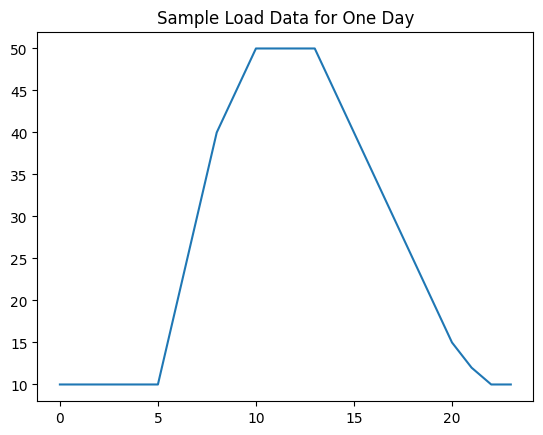

In [13]:
# Sample hourly load profile data in MW
load_data = {
    'hour': range(24),
    'demand_mw': [
        10, 10, 10, 10, 10, 10,  # 00:00 - 05:00 Low demand
        20, 30, 40, 45, 50, 50,  # 06:00 - 11:00 Increasing demand
        50, 50, 45, 40, 35, 30,  # 12:00 - 17:00 High demand
        25, 20, 15, 12, 10, 10   # 18:00 - 23:00 Decreasing demand
    ]
}

# Create a DataFrame
load_profile_df = pd.DataFrame(load_data)

# Display the DataFrame
load_profile_df['demand_mw'].plot(title="Sample Load Data for One Day")

<Axes: title={'center': 'Costs for One Day'}>

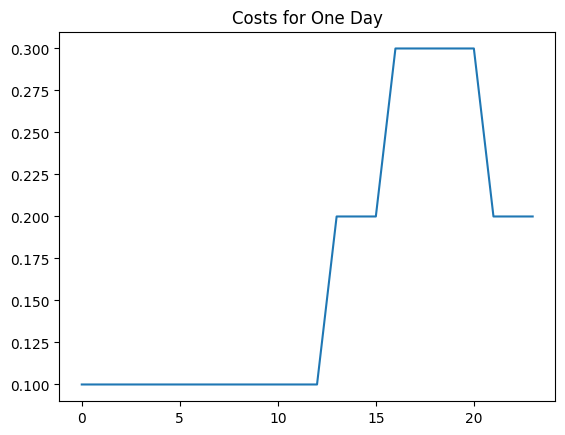

In [14]:
# Sample hourly energy cost data in $/MW
# Highest costs, the "peak period", is from 16:00-21:00 
# The partial peak period is 3 hours before and 3 hours after the peak period
cost_data = {
    'hour': range(24),
    'cost_mw': [
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 00:00 - 05:00 Low cost
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1,  # 06:00 - 11:00 Low cost
        0.1, 0.2, 0.2, 0.2, 0.3, 0.3,  # 12:00 - 17:00 Low-Med-High cost
        0.3, 0.3, 0.3, 0.2, 0.2, 0.2   # 18:00 - 23:00 High-Med-Low cost
    ]
}

# Create a DataFrame
cost_profile_df = pd.DataFrame(cost_data)

# Display the DataFrame
cost_profile_df['cost_mw'].plot(title="Costs for One Day")

In [15]:
# Combine load and cost dataframes
load_cost = load_profile_df.copy()
load_cost["cost_mw"] = cost_profile_df['cost_mw']
load_cost.set_index("hour", inplace=True)

load_cost

,demand_mw,cost_mw
hour,,
0,10,0.1
1,10,0.1
2,10,0.1
3,10,0.1
4,10,0.1
5,10,0.1
6,20,0.1
7,30,0.1
8,40,0.1


Decision Variables
- C_t is the amount of energy (MWh) charged in hour t
- D_t is the amount of energy (MWh) discharged in hour t
- SOC_t is the amount of energy (MWh) available in the battery in hour t
- Grid_t is the amount of energy (MWh) drawn from the grid in hour t

Parameters
- ESS_CAPACITY: the maximum battery capacity in MWh
- ESS_CHARGE_RATE: the maximum battery charge rate in MW
- ESS_DISCHARGE_RATE: the maximum battery discharge rate in MW
- RTE: the the round trip efficiency of the battery in percent (%)
- demand_t or demand_mw: the demand of the load at hour t (MWh)
- price_t or cost_mw: the cost of the energy at hour t ($/MWh)

Constraints
- 0 <= SOC_t <= ESS_CAPACITY for t from 0-24
- 0 <= C_t <= ESS_CHARGE_RATE
- 0 <= D_t <= ESS_DISCHARGE_RATE
- D_t <= SOC_t
- SOC_t = SOC_t-1 + C_t - D_t/RTE  (accounting for RTE losses) for t from 0-24
- D_t + grid_t >= demand_t
- SOC_0 = 0 initial boundary condition
- grid_t = max(demand_t - D_t, 0)
- D_t * C_t = 0 (note that i model this differently using binary decision variables, see below)

Objective
- Minimize the cost of energy for the building load across one day using a battery
min(sum((grid_t)*price_t) for t from 0-24)

In [16]:
# Initialize parameters
ESS_CAPACITY = 30 # MWH
ESS_CHARGE_RATE = 15 # MW
ESS_DISCHARGE_RATE = 15 # MW
RTE = 0.88

# demand_t is the column demand_mw from the load_cost dataframe
# price_t is the column cost_mw from the load_cost dataframe

In [17]:
# Create a PuLP model
model = pulp.LpProblem("Battery Optimization", pulp.LpMinimize)

# Decision Variables
charge = pulp.LpVariable.dicts("Charge", load_cost.index, lowBound=0, cat='Continuous')
discharge = pulp.LpVariable.dicts("Discharge", load_cost.index, lowBound=0, cat='Continuous')
soc = pulp.LpVariable.dicts("SOC", load_cost.index, lowBound=0, cat='Continuous')
grid = pulp.LpVariable.dicts("Grid", load_cost.index, lowBound=0, cat='Continuous')

# Since charge[t] * discharge[t] == 0 is a non-linear problem we re-establish using binary variables
is_charging = pulp.LpVariable.dicts("IsCharging", load_cost.index, cat='Binary')
is_discharging = pulp.LpVariable.dicts("IsDischarging", load_cost.index, cat='Binary')

# Establish RTE inverse since PuLP does not allow division by float
RTE_inverse = 1/RTE

# Objective Function
model += pulp.lpSum([grid[t] * load_cost.cost_mw[t] for t in load_cost.index])

# Constraints
for t in load_cost.index:
    if t == 0:
        # Initial boundary condition
        model += soc[t] == 0
    else:
        # SOC constraint
        model += 0 <= soc[t] <= ESS_CAPACITY
        # Maximum charge/discharge rate constraints
        model += charge[t] <= ESS_CHARGE_RATE * is_charging[t]
        model += discharge[t] <= ESS_DISCHARGE_RATE * is_discharging[t]
        # Discharge cannot be greater than SOC available
        model += discharge[t] <= soc[t]
        # Account for RTE when calculating SOC
        model += soc[t] == soc[t-1] + charge[t] - discharge[t] * RTE_inverse
        # Ensure building demand is met
        model += discharge[t] + grid[t] >= load_cost.demand_mw[t]
        # Define grid, ensure it cannot go negative 
        model += grid[t] == load_cost.demand_mw[t] - discharge[t] + charge[t]
        model += grid[t] >= 0
        # Ensure battery can't charge and discharge simultaneously
        model += is_charging[t] + is_discharging[t] <= 1

# Solve the model
model.solve()

# Print the results
for t in load_cost.index:
    print(f"Hour {load_cost.index}: Charge = {charge[t].varValue} MWh, Discharge = {discharge[t].varValue} MWh")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/5e4febd9dae042ad8a141a4153010f3a-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/5e4febd9dae042ad8a141a4153010f3a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 213 COLUMNS
At line 768 RHS
At line 977 BOUNDS
At line 1024 ENDATA
Problem MODEL has 208 rows, 140 columns and 438 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 99.5515 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 127 rows, 118 columns (44 integer (44 of which binary)) and 306 elements
Cbc0038I Initial state - 8 integers unsatisfied sum - 

/Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [18]:

# Extracting results from the PuLP model
results = {
    'Hour': load_cost.index,
    'Charge': [charge[t].varValue for t in load_cost.index],
    'Discharge': [discharge[t].varValue for t in load_cost.index],
    'SOC': [soc[t].varValue for t in load_cost.index],
    'Grid': [grid[t].varValue for t in load_cost.index],
    'Demand': load_cost['demand_mw'],
    'Cost': load_cost['cost_mw']
}

results_df = pd.DataFrame(results).set_index('Hour')


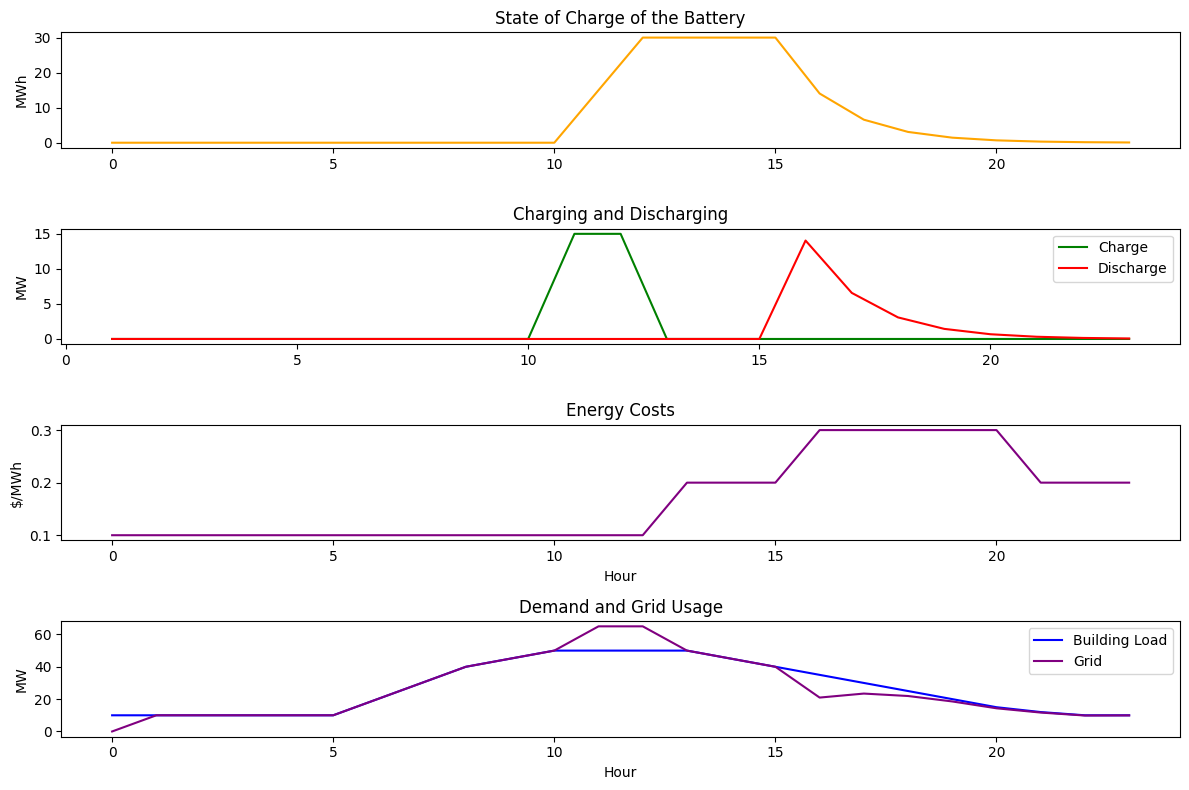

In [19]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(results_df.index, results_df['SOC'], label='State of Charge', color='orange')
plt.ylabel('MWh')
plt.title('State of Charge of the Battery')

plt.subplot(4, 1, 2)
plt.plot(results_df.index, results_df['Charge'], label='Charge', color='green')
plt.plot(results_df.index, results_df['Discharge'], label='Discharge', color='red')
plt.ylabel('MW')
plt.legend()
plt.title('Charging and Discharging')

plt.subplot(4, 1, 3)
plt.plot(results_df.index, results_df['Cost'], label='Energy Costs', color='purple')
plt.xlabel('Hour')
plt.ylabel('$/MWh')
plt.title('Energy Costs')

plt.subplot(4, 1, 4)
plt.plot(results_df.index, results_df['Demand'], label='Building Load', color='blue')
plt.plot(results_df.index, results_df['Grid'], label='Grid', color='purple')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.title('Demand and Grid Usage')

plt.legend()
plt.tight_layout()
plt.show()


In [20]:
# Given that in the real world, a battery needs to have smooth charging and discharging, I want to impose 
# a smoothing function. This is tricky given that we are operating with a linear program, but I can place a small penalty on the battery for 
# switching state, which may achieve this result

In [21]:
# Create a PuLP model
model = pulp.LpProblem("Battery Optimization", pulp.LpMinimize)

# Decision Variables
charge = pulp.LpVariable.dicts("Charge", load_cost.index, lowBound=0, cat='Continuous')
discharge = pulp.LpVariable.dicts("Discharge", load_cost.index, lowBound=0, cat='Continuous')
soc = pulp.LpVariable.dicts("SOC", load_cost.index, lowBound=0, cat='Continuous')
grid = pulp.LpVariable.dicts("Grid", load_cost.index, lowBound=0, cat='Continuous')

# Since charge[t] * discharge[t] == 0 is a non-linear problem we re-establish using binary variables
is_charging = pulp.LpVariable.dicts("IsCharging", load_cost.index, cat='Binary')
is_discharging = pulp.LpVariable.dicts("IsDischarging", load_cost.index, cat='Binary')

# Create a persistent state decision variable for charging and discharging
persistent_charge = pulp.LpVariable.dicts("PersistentCharge", load_cost.index, lowBound=0, cat='Continuous')
persistent_discharge = pulp.LpVariable.dicts("PersistentDischarge", load_cost.index, lowBound=0, cat='Continuous')

# Establish RTE inverse since PuLP does not allow division by float
RTE_inverse = 1/RTE

# Add a small cost to the objective function for each change in persistence
SWITCH_COST = 0.05  # A small cost to disincentivize switching (equivalent to half the off peak price)

# Objective Function
model += pulp.lpSum([grid[t] * load_cost.cost_mw[t] for t in load_cost.index]) + SWITCH_COST * (pulp.lpSum([persistent_charge[t] for t in load_cost.index[1:]]) + pulp.lpSum([persistent_discharge[t] for t in load_cost.index[1:]]))

# Constraints
for t in load_cost.index:
    if t == 0:
        # Initial boundary condition
        model += soc[t] == 0
        model += persistent_charge[t] == 0
        model += persistent_discharge[t] == 0
    else:
        # SOC constraint
        model += 0 <= soc[t] <= ESS_CAPACITY
        # Maximum charge/discharge rate constraints
        model += charge[t] <= ESS_CHARGE_RATE * is_charging[t]
        model += discharge[t] <= ESS_DISCHARGE_RATE * is_discharging[t]
        # Discharge cannot be greater than SOC available
        model += discharge[t] <= soc[t]
        # Account for RTE when calculating SOC
        model += soc[t] == soc[t-1] + charge[t] - discharge[t] * RTE_inverse
        # Ensure building demand is met
        model += discharge[t] + grid[t] >= load_cost.demand_mw[t]
        # Define grid, ensure it cannot go negative 
        model += grid[t] == load_cost.demand_mw[t] - discharge[t] + charge[t]
        model += grid[t] >= 0
        # Ensure battery can't charge and discharge simultaneously
        model += is_charging[t] + is_discharging[t] <= 1
        # Charging persistence constraints
        model += persistent_charge[t] >= charge[t] - charge[t-1]
        model += persistent_charge[t] >= charge[t-1] - charge[t]
        # Discharging persistence constraints
        model += persistent_discharge[t] >= discharge[t] - discharge[t-1]
        model += persistent_discharge[t] >= discharge[t-1] - discharge[t]

# Solve the model
model.solve()

# Print the results
for t in load_cost.index:
    print(f"Hour {load_cost.index}: Charge = {charge[t].varValue} MWh, Discharge = {discharge[t].varValue} MWh")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/zoemcbride/repos/energy-data-lab/energy-venv/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c7a43dabada94ad2b7831ce048bc3985-pulp.mps timeMode elapsed branch printingOptions all solution /var/folders/x0/bk3p3l3n03dbdfrh_pj34p3r0000gp/T/c7a43dabada94ad2b7831ce048bc3985-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 307 COLUMNS
At line 1186 RHS
At line 1489 BOUNDS
At line 1536 ENDATA
Problem MODEL has 302 rows, 190 columns and 716 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 100.402 - 0.00 seconds
Cgl0003I 0 fixed, 0 tightened bounds, 4 strengthened rows, 0 substitutions
Cgl0004I processed model has 218 rows, 166 columns (46 integer (46 of which binary)) and 579 elements
Cbc0038I Initial state - 20 integers unsatisfied sum

In [22]:

# Extracting results from the PuLP model
results = {
    'Hour': load_cost.index,
    'Charge': [charge[t].varValue for t in load_cost.index],
    'Discharge': [discharge[t].varValue for t in load_cost.index],
    'SOC': [soc[t].varValue for t in load_cost.index],
    'Grid': [grid[t].varValue for t in load_cost.index],
    'Demand': load_cost['demand_mw'],
    'Cost': load_cost['cost_mw']
}

results_df = pd.DataFrame(results).set_index('Hour')


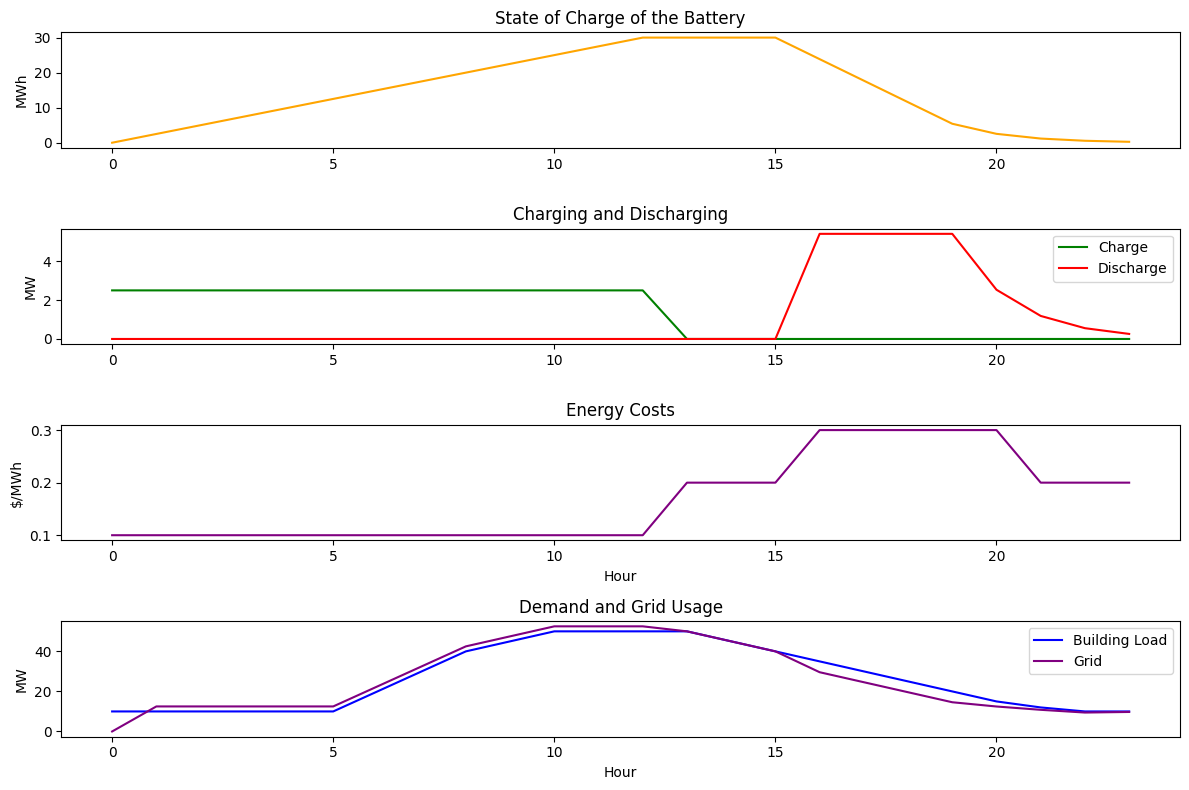

In [23]:
# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(results_df.index, results_df['SOC'], label='State of Charge', color='orange')
plt.ylabel('MWh')
plt.title('State of Charge of the Battery')

plt.subplot(4, 1, 2)
plt.plot(results_df.index, results_df['Charge'], label='Charge', color='green')
plt.plot(results_df.index, results_df['Discharge'], label='Discharge', color='red')
plt.ylabel('MW')
plt.legend()
plt.title('Charging and Discharging')

plt.subplot(4, 1, 3)
plt.plot(results_df.index, results_df['Cost'], label='Energy Costs', color='purple')
plt.xlabel('Hour')
plt.ylabel('$/MWh')
plt.title('Energy Costs')

plt.subplot(4, 1, 4)
plt.plot(results_df.index, results_df['Demand'], label='Building Load', color='blue')
plt.plot(results_df.index, results_df['Grid'], label='Grid', color='purple')
plt.xlabel('Hour')
plt.ylabel('MW')
plt.title('Demand and Grid Usage')

plt.legend()
plt.tight_layout()
plt.show()


In [38]:
#grid #[2].varValue

To be continued on optimization_problems_ess_simulation.ipynb!

# Library Management System
Involves object-oriented programming, data handling, and basic logic implementation.

Background
- You are tasked with designing a simple library management system. The system should be able to handle books, patrons (people who borrow books), and the borrowing process.

Requirements
- Book Class:
    Each book should have attributes like title, author, ISBN, and a status indicating whether it's available or checked out.
    Implement methods to check out and return a book.
    Include a method to display book information.
    
- Patron Class:
    Each patron should have a name and a unique ID.
    Implement a method that allows a patron to check out or return books from the library.
    Include a method to display the patron's information and the books they currently have checked out.
    
- Library Class:
    The library should maintain a collection of books and a list of patrons.
    Implement methods to add or remove books and patrons.
    Include a method to search for books by title or author.
    Implement a check-out system where patrons can borrow available books.
    Ensure that the system handles the case where a book is not available for borrowing.
    
- Interaction:
    Simulate a scenario where several patrons visit the library, check out and return books.
    Display the status of different books and patrons to show the system's functionality.
    
- Bonus Challenge:
    Implement a fine system for books returned after a due date.
    Each day past the due date incurs a small fine. Keep track of the due date and fines for each book a patron has checked out.

Considerations
- Focus on clear and efficient code.
- Ensure proper encapsulation of data within classes.
- Consider edge cases and error handling, especially in the check-out and return processes.
- You don't need to implement a real-time system; simulate interactions with method calls.

In [354]:
class Book():
    def __init__(self, title, author, isbn, status='available'):
        self.title = title
        self.author = author
        self.isbn = isbn
        
        self.status = 'available'  # Default status
        self.set_status(status) # if the provided status is valid
        
    def get_status(self):
        return self.status

    def set_status(self, status):
        if status in ['available', 'checked out']:
            self.status = status
        
    def check_out_book(self):
        if self.status == 'available':
            print(f"{self.title} has been successfully checked out")
            self.set_status('checked out')
            return True
        else:
            raise ValueError(f"{self.title} is already checked out, and is not available.")

    def return_book(self):
        print(f"{self.title} has been successfully returned and is now available.")
        self.set_status('available')
        
    def display_book_information(self):
        # Print information about book and return dictionary pairing isbn to title.
        print(f"{self.title} by {self.author} has ISBN {self.isbn} and is currently {self.get_status()}.")
        

In [360]:
class Patron():
    """
    Each patron should have a name and a unique ID. 
    Implement a method that allows a patron to check out or return books from the library. 
    Include a method to display the patron's information and the books they currently have checked out.
    """
    
    def __init__(self, name, user_id):
        self.name = name
        self.user_id = user_id
        self.books_checked_out = dict()
    
    def patron_check_out(self, book=None):
        if book:
            if book.check_out_book():
                self.books_checked_out[book.isbn]= {'title':book.title, 'author':book.author}
            else:
                raise ValueError(f"{book.title} is already checked out, sorry.")
        else:
            raise ValueError("No book provided, cannot checkout")
        
        return self.books_checked_out
    
    def display_patron_info(self):
        if len(self.books_checked_out)==0:
            print(f"{self.name}, id {self.user_id}, has no books checked out.")
        else:
            print(f"{self.name}, id {self.user_id} has the following books checked out: {[book['title'] for book in self.books_checked_out.values()]}")
        

In [362]:
class Library():
    """
    Library Class: The library should maintain a collection of books and a list of patrons. 
    Implement methods to add or remove books and patrons. 
    Include a method to search for books by title or author. 
    Implement a check-out system where patrons can borrow available books. 
    Ensure that the system handles the case where a book is not available for borrowing.
    """
    def __init__(self, book_list=None, patron_list=None):
        self.book_list = book_list if book_list is not None else []
        self.patron_list = patron_list if patron_list is not None else []
    
    def add_book(self, book=None):
        if book:
            if len(self.book_list)>0:
                self.book_list.append(book)
            else:
                self.book_list = [book]
        else:
            raise ValueError("No book provided, cannot add book.")
    
    def remove_book(self, book=None):
        if book:
            if book in self.book_list:
                self.book_list.remove(book)
            else:
                raise ValueError("Book is not in the system.")
        else:
            raise ValueError("No book provided, cannot remove book.")
    
    def add_patron(self, patron=None):
        if patron:
            self.patron_list.append(patron)
        else:
            raise ValueError("No patron provided, cannot add patron.")
    
    def remove_patron(self, patron=None):
        if patron:
            self.patron_list.remove(patron)
        else:
            raise ValueError("No patron provided, cannot remove patron.")
        
    def find_book(self, title_to_find=None, author_to_find=None):
        books_found = 0
        
        if title_to_find:
            for index, book in enumerate(self.book_list):
                if book.title == title_to_find:
                    print(f"The author of {book.title} is {book.author} and has ISBN {book.isbn} and it is {book.status}.")
                    books_found += 1
        elif author_to_find:
            for index, book in enumerate(self.book_list):
                if book.author == author_to_find:
                    print(f"The author {book.author} has the book {book.title} with ISBN {book.isbn} and it is {book.status}.")
                    books_found += 1
        if books_found == 0:
                print(f"{title_to_find}{author_to_find} not found in the system.")
    

In [357]:
harry_potter_1 = Book(title="Harry Potter and the Sorcerer's Stone", author="J.K. Rowling", isbn=12345, status='available')
harry_potter_1.display_book_information()

hearts_invisible = Book(title="The Heart's Invisible Furies", author="John Boyne", isbn=23456, status='available')
hearts_invisible.display_book_information()

harry_potter_2 = Book(title="Harry Potter and the Chamber of Secrets", author="J.K. Rowling", isbn=34567, status='available')
harry_potter_2.display_book_information()

zoe_m = Patron(name='Zoe McBride', user_id=77777)
zoe_m.display_patron_info()

Harry Potter and the Sorcerer's Stone by J.K. Rowling has ISBN 12345 and is currently available.
The Heart's Invisible Furies by John Boyne has ISBN 23456 and is currently available.
Harry Potter and the Chamber of Secrets by J.K. Rowling has ISBN 34567 and is currently available.
Zoe McBride, id 77777, has no books checked out.


In [358]:
zoe_m.patron_check_out(harry_potter_1)
zoe_m.patron_check_out(hearts_invisible)
zoe_m.display_patron_info()

harry_potter_1.display_book_information()
hearts_invisible.display_book_information()


Harry Potter and the Sorcerer's Stone has been successfully checked out
The Heart's Invisible Furies has been successfully checked out
Zoe McBride, id 77777 has the following books checked out: ["Harry Potter and the Sorcerer's Stone", "The Heart's Invisible Furies"]
Harry Potter and the Sorcerer's Stone by J.K. Rowling has ISBN 12345 and is currently checked out.
The Heart's Invisible Furies by John Boyne has ISBN 23456 and is currently checked out.


In [359]:
main_library = Library()
main_library.add_book(harry_potter_1)
main_library.add_book(hearts_invisible)
main_library.add_book(harry_potter_2)
main_library.add_patron(zoe_m)
main_library.find_book(author_to_find="J.K. Rowling")

The author J.K. Rowling has the book Harry Potter and the Sorcerer's Stone with ISBN 12345 and it is checked out.
The author J.K. Rowling has the book Harry Potter and the Chamber of Secrets with ISBN 34567 and it is available.


# Pandas - Weather Data

 This dataset includes daily entries for the entire year 2022, containing information on temperature (in degrees Celsius), humidity (in percentage), and wind speed (in km/h).

Data Preparation:

- Load the data into a DataFrame.
- Check for and handle any inconsistencies or missing values in the data.
- Convert the Date column to a datetime type and set it as the index.

Data Aggregation and Analysis:

- Calculate the average temperature and humidity for each city.
- Identify the city with the highest average wind speed.
- Create a pivot table showing the median temperature for each city by month.
- Generate a plot to visualize the variation of temperatures over time for a selected city.

In [119]:
weather_data = pd.read_csv("data/dummy_weather_data.csv")

In [120]:
weather_data.head()

,Date,City,Temperature (F),Humidity,Wind Speed (mph),Weather Condition
0,2022-01-01,Los Angeles,39.790638,49.419745,0.396358,Sunny
1,2022-01-01,New York,73.044763,43.454983,4.031570,Cloudy
2,2022-01-01,Houston,60.104874,45.303357,3.844551,Windy
3,2022-01-02,Los Angeles,77.911914,78.454325,7.671405,Foggy
4,2022-01-02,New York,81.245923,35.973827,1.763942,Sunny


In [121]:
# Convert Date column to datetime; set index to Date column
weather_data["Date"] = pd.to_datetime(weather_data["Date"])
weather_data.set_index("Date", inplace=True)

In [122]:
weather_data.head()

,City,Temperature (F),Humidity,Wind Speed (mph),Weather Condition
Date,,,,,
2022-01-01,Los Angeles,39.790638,49.419745,0.396358,Sunny
2022-01-01,New York,73.044763,43.454983,4.031570,Cloudy
2022-01-01,Houston,60.104874,45.303357,3.844551,Windy
2022-01-02,Los Angeles,77.911914,78.454325,7.671405,Foggy
2022-01-02,New York,81.245923,35.973827,1.763942,Sunny


In [123]:
for city in weather_data["City"].unique():
    print(f"Checking {city}...")
    # Check for time gaps -- looks OK
    print("Checking time gaps:")
    print(weather_data[weather_data["City"]==city].index.to_series().diff().value_counts())
    
    
    print("\n")

Checking Los Angeles...
Checking time gaps:
Date
1 days    364
Name: count, dtype: int64


Checking New York...
Checking time gaps:
Date
1 days    364
Name: count, dtype: int64


Checking Houston...
Checking time gaps:
Date
1 days    364
Name: count, dtype: int64




In [124]:
# Check for nan values -- looks OK
print("Checking for NaN values:")
if len(weather_data[weather_data["Temperature (F)"].isna()==True])==0:
    print("Temperature has no missing NaN")
if len(weather_data[weather_data["Humidity"].isna()==True])==0:
    print("Humidity has no missing NaN")
if len(weather_data[weather_data["Wind Speed (mph)"].isna()==True])==0:
    print("Wind Speed has no missing NaN")

Checking for NaN values:
Temperature has no missing NaN
Humidity has no missing NaN
Wind Speed has no missing NaN


In [125]:
# Intuition check on the data -- looks OK
weather_data.describe()

,Temperature (F),Humidity,Wind Speed (mph)
count,1095.000000,1095.000000,1095.000000
mean,55.077747,58.982063,4.508180
std,23.343288,22.735467,2.639470
min,14.073166,20.005796,0.013692
25%,35.771701,39.575484,2.246871
50%,54.785753,58.165944,4.505154
75%,75.579367,78.383764,6.800512
max,94.997086,99.994492,9.320161


<Axes: title={'center': 'Houston'}>

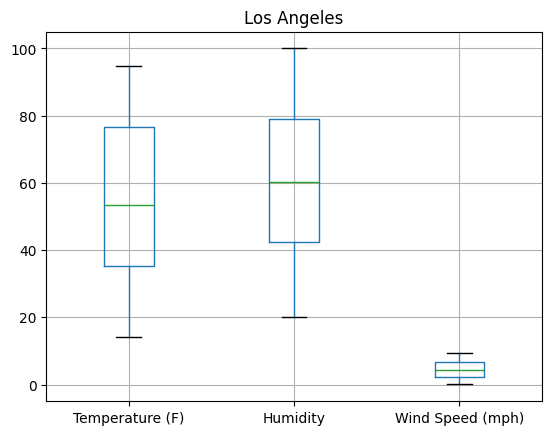

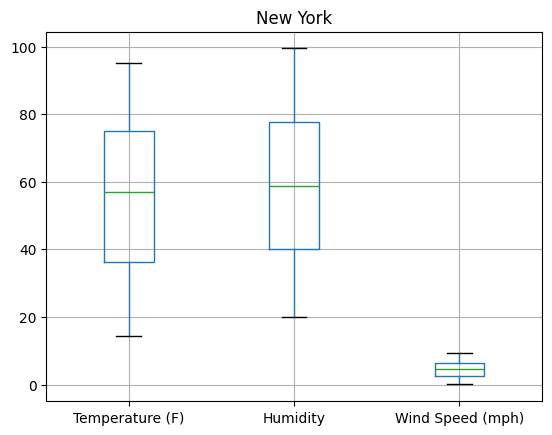

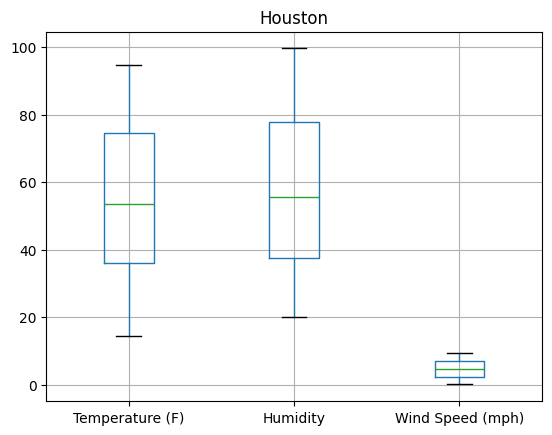

In [126]:
# Data is randomly generated, so does not necessarily represent actual climates in these cities
plt.figure()
plt.title("Los Angeles")
weather_data[weather_data["City"]=="Los Angeles"].boxplot()
plt.figure()
plt.title("New York")
weather_data[weather_data["City"]=="New York"].boxplot()
plt.figure()
plt.title("Houston")
weather_data[weather_data["City"]=="Houston"].boxplot()

In [144]:
city_groupings = weather_data.groupby("City")

for city, group in city_groupings:
     #weather_data[weather_data["City"]==city]
    print(city, "Average temperature:", round(group["Temperature (F)"].mean(),2), "*F")
    print(city, "Average Humidity:", round(group["Humidity"].mean(),2), "%")
    print(city, "Average Windspeed:", round(group["Wind Speed (mph)"].mean(),2), "mph")
    
weather_data[weather_data["Wind Speed (mph)"] == weather_data["Wind Speed (mph)"].max()]

Houston Average temperature: 54.34 *F
Houston Average Humidity: 57.31 %
Houston Average Windspeed: 4.67 mph
Los Angeles Average temperature: 55.63 *F
Los Angeles Average Humidity: 60.29 %
Los Angeles Average Windspeed: 4.4 mph
New York Average temperature: 55.26 *F
New York Average Humidity: 59.34 %
New York Average Windspeed: 4.46 mph


,City,Temperature (F),Humidity,Wind Speed (mph),Weather Condition
Date,,,,,
2022-09-01,Houston,37.022851,22.28011,9.320161,Foggy


In [137]:
weather_data[["City","Temperature (F)"]].groupby("City").resample("M").median() #

Temperature (F)
City        Date                       
Houston     2022-01-31        60.104874
            2022-02-28        54.586222
            2022-03-31        48.624374
            2022-04-30        60.981684
            2022-05-31        59.257210
            2022-06-30        62.258406
            2022-07-31        49.040328
            2022-08-31        46.166071
            2022-09-30        46.449366
            2022-10-31        58.236753
            2022-11-30        39.100297
            2022-12-31        51.456538
Los Angeles 2022-01-31        51.747761
            2022-02-28        54.486772
            2022-03-31        49.303138
            2022-04-30        65.706797
            2022-05-31        55.041796
            2022-06-30        56.497337
            2022-07-31        33.844207
            2022-08-31        67.259112
            2022-09-30        60.390747
            2022-10-31        52.492337
            2022-11-30        63.185714
            2022-12-31        49.178500
New York    2022-01-31        60.626360
            2022-02-28        60.645697
            2022-03-31        42.544977
            2022-04-30        51.979869
            2022-05-31        51.392788
            2022-06-30        64.070326
            2022-07-31        62.028652
            2022-08-31        49.180722
            2022-09-30        53.791755
            2022-10-31        54.876342
            2022-11-30        63.502920
            2022-12-31        58.664232

<Axes: xlabel='Date'>

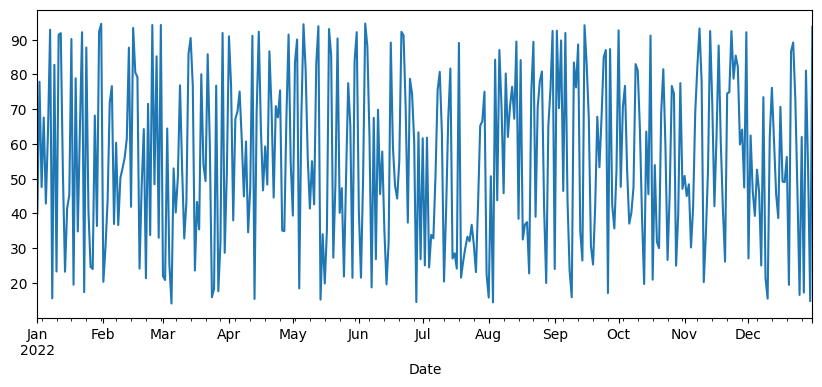

In [143]:
plt.figure(figsize=(10,4))
weather_data[weather_data["City"]=="Los Angeles"]["Temperature (F)"].plot()

# Pandas - Sales Exercise

Scenario:
You are provided with a CSV file named sales_data.csv. This file contains sales data for a retail company and includes columns like Date, ProductID, ProductName, Category, UnitPrice, Quantity, and StoreLocation.

Task:

Data Cleaning and Preparation:

- Load the CSV file into a pandas DataFrame.
- Handle any missing values in the dataset.
- Convert the Date column to a datetime object in pandas.
- Create a new column named TotalSales, which is the product of UnitPrice and Quantity.


Data Analysis:

- Calculate the total sales for each Category.
- Find the top 3 best-selling products in terms of quantity sold.
- Determine the average unit price of products for each StoreLocation.
- Plot a time series graph showing the monthly total sales

In [261]:
sales_data = pd.read_csv("data/sales_data.csv")

In [262]:
# Convert date column to datetime and set as index
sales_data["Date"] = pd.to_datetime(sales_data["Date"])
sales_data.set_index("Date", inplace=True)

sales_data.head()

,ProductID,ProductName,Category,UnitPrice,Quantity,StoreLocation
Date,,,,,,
2022-01-01,1044,Product_1044,Electronics,441.345826,6.0,San Francisco
2022-01-02,1047,Product_1047,Books,163.709272,5.0,San Francisco
2022-01-03,1064,Product_1064,Furniture,479.150919,14.0,New York
2022-01-04,1067,Product_1067,Books,241.158270,6.0,Houston
2022-01-05,1067,Product_1067,Books,358.676070,12.0,Los Angeles


In [263]:
sales_data.describe()

,ProductID,UnitPrice,Quantity
count,365.000000,355.000000,360.000000
mean,1049.041096,256.953567,10.038889
std,28.359466,139.056055,5.637483
min,1000.000000,11.983572,1.000000
25%,1026.000000,142.829825,5.000000
50%,1047.000000,256.679440,10.000000
75%,1073.000000,371.882884,15.000000
max,1099.000000,496.290466,19.000000


In [264]:
# Identify missing values in dates -- looks OK
sales_data.index.to_series().diff().value_counts()

Date
1 days    364
Name: count, dtype: int64

In [265]:
# Identify missing values in columns -- looks like there are NaNs in UnitPrice and Quantity columns
for col in sales_data.columns:
    if len(sales_data[sales_data[col].isna()==True])==0:
        print(f"{col} contains no NaNs")
    else:
        print(f"{col} contains NaNs:")
        print(sales_data[sales_data[col].isna()==True])
        

ProductID contains no NaNs
ProductName contains no NaNs
Category contains no NaNs
UnitPrice contains NaNs:
            ProductID   ProductName     Category  UnitPrice  Quantity  \
Date                                                                    
2022-01-07       1083  Product_1083     Clothing        NaN       1.0   
2022-01-14       1012  Product_1012  Electronics        NaN       7.0   
2022-02-17       1074  Product_1074     Clothing        NaN      14.0   
2022-06-16       1098  Product_1098  Electronics        NaN       9.0   
2022-07-29       1054  Product_1054    Furniture        NaN       2.0   
2022-08-08       1067  Product_1067     Clothing        NaN       1.0   
2022-08-15       1069  Product_1069         Toys        NaN       7.0   
2022-08-31       1051  Product_1051    Furniture        NaN       3.0   
2022-09-29       1034  Product_1034        Books        NaN      16.0   
2022-10-22       1035  Product_1035  Electronics        NaN      10.0   

            Stor

In [266]:
print(f"UnitPrice column contains {round(sales_data['UnitPrice'].isna().sum()/len(sales_data)*100,2)}% missing data")
print(f"Quantity column contains {round(sales_data['Quantity'].isna().sum()/len(sales_data)*100,2)}% missing data")

# Pandas will automatically drop these nans in calculations, and given they are small in nature, this is acceptable behavior


UnitPrice column contains 2.74% missing data
Quantity column contains 1.37% missing data


In [267]:
# Option to drop NaNs
sales_data.dropna(how="any", inplace=True)

# Alternatively, given how small the number of missing data points are, I wouldn't fill them in, but you could:
#sales_data[["UnitPrice","Quantity"]].fillna(sales_data[["UnitPrice","Quantity"]].mean())

In [268]:
sales_data["TotalSales"] = sales_data["UnitPrice"] * sales_data["Quantity"]
sales_data.head()

,ProductID,ProductName,Category,UnitPrice,Quantity,StoreLocation,TotalSales
Date,,,,,,,
2022-01-01,1044,Product_1044,Electronics,441.345826,6.0,San Francisco,2648.074953
2022-01-02,1047,Product_1047,Books,163.709272,5.0,San Francisco,818.546362
2022-01-03,1064,Product_1064,Furniture,479.150919,14.0,New York,6708.112870
2022-01-04,1067,Product_1067,Books,241.158270,6.0,Houston,1446.949618
2022-01-05,1067,Product_1067,Books,358.676070,12.0,Los Angeles,4304.112844


<Axes: xlabel='Category'>

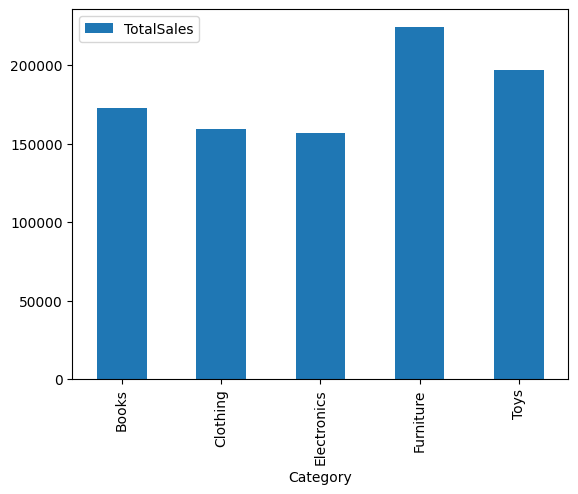

In [269]:
# Calculate the total sales for each Category.
sales_data[["Category","TotalSales"]].groupby("Category").sum()

sales_data[["Category","TotalSales"]].groupby("Category").sum().plot.bar()

In [270]:
sales_data.sort_values(by="TotalSales", ascending=False).groupby("Category").head(n=3)

,ProductID,ProductName,Category,UnitPrice,Quantity,StoreLocation,TotalSales
Date,,,,,,,
2022-02-27,1053,Product_1053,Electronics,492.665817,19.0,San Francisco,9360.650516
2022-07-09,1029,Product_1029,Furniture,491.003443,19.0,Boston,9329.065425
2022-09-23,1039,Product_1039,Furniture,488.118326,18.0,Boston,8786.129863
2022-07-31,1011,Product_1011,Electronics,484.762490,18.0,New York,8725.724822
2022-11-12,1070,Product_1070,Clothing,458.247424,19.0,Los Angeles,8706.701047
2022-11-26,1091,Product_1091,Furniture,444.759771,19.0,Houston,8450.435655
2022-03-18,1014,Product_1014,Electronics,463.844336,18.0,New York,8349.198044
2022-06-10,1077,Product_1077,Toys,475.155762,17.0,San Francisco,8077.647953
2022-09-30,1088,Product_1088,Toys,448.482964,17.0,Boston,7624.210391


In [271]:
# Find the top 3 best-selling products in terms of quantity sold.
sales_data[["ProductName","Quantity","TotalSales"]].groupby("ProductName").sum().sort_values(by="Quantity", ascending=False).head(n=3)


,Quantity,TotalSales
ProductName,,
Product_1067,89.0,13075.111185
Product_1039,83.0,28548.763179
Product_1000,76.0,24437.085952


In [272]:
# Determine the average unit price of products for each StoreLocation.

sales_data[["StoreLocation","UnitPrice"]].groupby("StoreLocation").mean()
# NY has the highest unitprice on average, LA has the lowest unit price on average

,UnitPrice
StoreLocation,
Boston,267.260572
Houston,254.527472
Los Angeles,240.785440
New York,270.556787
San Francisco,259.236312


([<matplotlib.axis.XTick at 0x131406d60>,
 [Text(0, 0, 'Jan'),
  Text(1, 0, 'Feb'),
  Text(2, 0, 'mar'),
  Text(3, 0, 'apr'),
  Text(4, 0, 'may'),
  Text(5, 0, 'june'),
  Text(6, 0, 'july'),
  Text(7, 0, 'aug'),
  Text(8, 0, 'sept'),
  Text(9, 0, 'oct'),
  Text(10, 0, 'nov'),
  Text(11, 0, 'dec')])

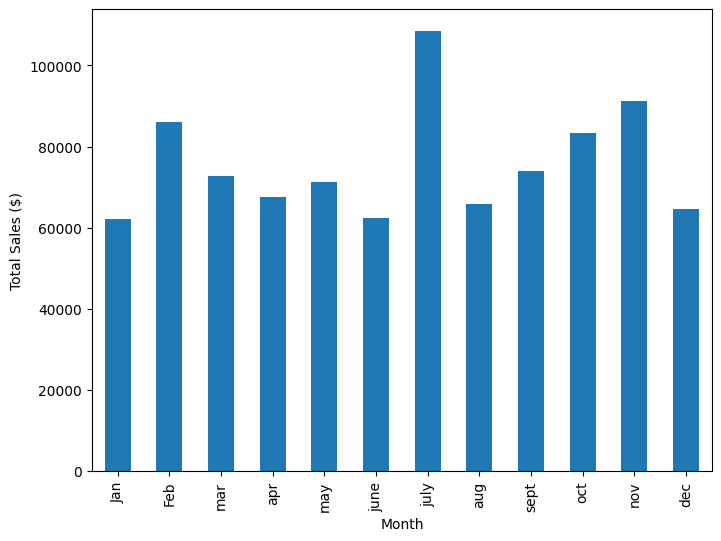

In [273]:
# Plot a time series graph showing the monthly total sales
plt.figure(figsize=(8,6))
sales_data["TotalSales"].resample("1M").sum().plot.bar()
plt.xlabel("Month")
plt.ylabel("Total Sales ($)")
plt.xticks(ticks=np.arange(0,12), labels=["Jan","Feb","mar","apr","may","june","july","aug","sept","oct","nov","dec"])

# Pandas Manipulation - Customer Segmentation

- Load the CSV file into a pandas DataFrame.
- Perform basic data cleaning, including handling any missing values and ensuring correct data types.
- Create a new column named Age Group to categorize customers into 'Young' (Age <= 30), 'Middle-Aged' (31 <= Age <= 60), and 'Senior' (Age > 60).
- Calculate the average annual income and spending score for each Age Group.
- Identify the gender distribution within each Age Group.

In [335]:
customer_segmentation = pd.read_csv("data/customer_data.csv")
customer_segmentation.head()

,CustomerID,Age,Gender,Annual Income (k$),Spending Score (1-100)
0,1001,62.0,Female,100.0,36
1,1002,65.0,Female,115.0,92
2,1003,18.0,Female,61.0,41
3,1004,21.0,Male,43.0,37
4,1005,21.0,Female,101.0,49


In [336]:
customer_segmentation.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,100.000000,95.000000,95.000000,100.000000
mean,1050.500000,41.452632,84.442105,52.100000
std,29.011492,15.566445,32.988301,29.369984
min,1001.000000,18.000000,30.000000,1.000000
25%,1025.750000,29.000000,60.000000,26.000000
50%,1050.500000,41.000000,83.000000,51.000000
75%,1075.250000,54.500000,112.500000,80.000000
max,1100.000000,69.000000,148.000000,100.000000


In [337]:
# Check for NaNs and print them if present
for col in customer_segmentation.columns:
    if customer_segmentation[col].isna().sum() == 0:
        print(f"{col} contains no NaNs \n")
    else:
        print(f"{col} DOES contain NaNs:")
        print(customer_segmentation[customer_segmentation[col].isna()],"\n")

CustomerID contains no NaNs 

Age DOES contain NaNs:
    CustomerID  Age  Gender  Annual Income (k$)  Spending Score (1-100)
5         1006  NaN  Female                86.0                      26
32        1033  NaN   Other                91.0                      44
42        1043  NaN   Other               137.0                      92
77        1078  NaN  Female                69.0                      43
85        1086  NaN    Male                63.0                     100 

Gender contains no NaNs 

Annual Income (k$) DOES contain NaNs:
    CustomerID   Age  Gender  Annual Income (k$)  Spending Score (1-100)
47        1048  19.0    Male                 NaN                       1
55        1056  68.0    Male                 NaN                      68
63        1064  58.0  Female                 NaN                      20
66        1067  22.0    Male                 NaN                      88
93        1094  54.0   Other                 NaN                       9 

Spending 

In [338]:
# Age and annual income columns do contain NaNs. Given there are 100 data points and 5 missing, that represents 5% 
# of the data missing per column, or 10% if the entire row is dropped. That's not huge but it could be worth looking
# into filling the gaps instead.
#
# To fill the gaps, I'll start by analyzing smaller segments of the data first
#sns.lineplot(data=customer_segmentation, x='Age', y='Annual Income (k$)')
#sns.lineplot(data=customer_segmentation, x='Annual Income (k$)', y='Spending Score (1-100)')
# --> Appear to have no linear trend

customer_segmentation[(customer_segmentation['Annual Income (k$)']>80.0) & (customer_segmentation['Annual Income (k$)']<90.0)]



,CustomerID,Age,Gender,Annual Income (k$),Spending Score (1-100)
5,1006,NaN,Female,86.0,26
11,1012,41.0,Female,84.0,19
41,1042,47.0,Male,84.0,97
52,1053,41.0,Other,83.0,95
53,1054,53.0,Male,81.0,25
56,1057,46.0,Female,83.0,52


In [339]:
# Using a KNN Imputer we can fill NaNs using the most similar row
# KNN Imputer is chosen because it can estimate the missing values using the most similar rows based on other features.
# In our case, the assumption is that customers with similar spending scores and annual incomes will 
# likely be of similar ages.


from sklearn.impute import KNNImputer
customer_segmentation[['Annual Income (k$)','Age','Spending Score (1-100)']] = KNNImputer(n_neighbors=3).fit_transform(customer_segmentation[['Annual Income (k$)','Age','Spending Score (1-100)']])

customer_segmentation.isna().sum()

CustomerID                0
Age                       0
Gender                    0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [340]:
# We can see that the KNN imputer speculated that customer 1006 is around 50 yo.
# Looking at the similar rows above, this makes sense!

customer_segmentation[(customer_segmentation['Annual Income (k$)']==86.0) & (customer_segmentation['Gender'] == 'Female')]


,CustomerID,Age,Gender,Annual Income (k$),Spending Score (1-100)
5,1006,50.666667,Female,86.0,26.0


In [341]:
# Categorize customers into age groups based on the Age column
age_group = []

for age in customer_segmentation["Age"]:
    if age <= 30:
        age_group.append("Young")
    elif age <= 60:
        age_group.append("Middle Aged")
    else:
        age_group.append("Senior")

customer_segmentation["Age Group"] = age_group
customer_segmentation

,CustomerID,Age,Gender,Annual Income (k$),Spending Score (1-100),Age Group
0,1001,62.0,Female,100.0,36.0,Senior
1,1002,65.0,Female,115.0,92.0,Senior
2,1003,18.0,Female,61.0,41.0,Young
3,1004,21.0,Male,43.0,37.0,Young
4,1005,21.0,Female,101.0,49.0,Young
...,...,...,...,...,...,...
95,1096,32.0,Female,92.0,80.0,Middle Aged
96,1097,33.0,Female,38.0,54.0,Middle Aged
97,1098,38.0,Male,91.0,12.0,Middle Aged
98,1099,53.0,Male,31.0,5.0,Middle Aged


In [342]:
# Calculate the average annual income and spending score for each age group
customer_segmentation[["Annual Income (k$)","Spending Score (1-100)", "Age Group"]].groupby("Age Group").mean()

,Annual Income (k$),Spending Score (1-100)
Age Group,,
Middle Aged,85.790960,52.186441
Senior,97.242424,64.636364
Young,77.355556,47.333333


In [344]:
#Identify the gender distribution within each Age Group.
# Shown as percentages 
customer_segmentation[["Gender","Age Group"]].groupby("Age Group").value_counts(normalize=True)*100


Age Group    Gender
Middle Aged  Other     38.983051
             Male      33.898305
             Female    27.118644
Senior       Male      36.363636
             Other     36.363636
             Female    27.272727
Young        Female    40.000000
             Male      36.666667
             Other     23.333333
Name: proportion, dtype: float64

# Pandas & Rearranging data (pivot tables, groupby)

Using the provided DataFrame df, perform the following tasks using Python and Pandas:

- Create a pivot table that shows the average salary for each department.
- Add a column to the original DataFrame df that shows the number of years each employee has been with the company, assuming the current year is 2024.
- Filter the DataFrame to show only employees in the 'Engineering' department who have been with the company for at least 3 years.

In [345]:
# Sample Data
data = {
    'EmployeeID': [101, 102, 103, 104, 105],
    'Name': ['Alice', 'Bob', 'Charlie', 'David', 'Eva'],
    'Department': ['Sales', 'Engineering', 'Engineering', 'HR', 'Sales'],
    'JoiningYear': [2018, 2019, 2021, 2020, 2019],
    'Salary': [70000, 80000, 75000, 60000, 68000]
}

df = pd.DataFrame(data)

In [346]:
df.head()

,EmployeeID,Name,Department,JoiningYear,Salary
0,101,Alice,Sales,2018,70000
1,102,Bob,Engineering,2019,80000
2,103,Charlie,Engineering,2021,75000
3,104,David,HR,2020,60000
4,105,Eva,Sales,2019,68000


In [361]:
# One method, using groupby
df[['Department','Salary']].groupby(by="Department").mean()

# Second method, using pivot_table
df.pivot_table(values="Salary",index="Department", aggfunc="mean")

,Salary
Department,
Engineering,77500.0
HR,60000.0
Sales,69000.0


In [358]:
# Add JoiningYear
df["YearsAtCompany"] = 2024 - df["JoiningYear"]
df.head()

,EmployeeID,Name,Department,JoiningYear,Salary,YearsAtCompany
0,101,Alice,Sales,2018,70000,6
1,102,Bob,Engineering,2019,80000,5
2,103,Charlie,Engineering,2021,75000,3
3,104,David,HR,2020,60000,4
4,105,Eva,Sales,2019,68000,5


In [360]:
# Filter by only employees in the 'Engineering' department who have been with the company for at least 3 years
df[(df["Department"]=="Engineering")&(df["YearsAtCompany"]>3)]

,EmployeeID,Name,Department,JoiningYear,Salary,YearsAtCompany
1,102,Bob,Engineering,2019,80000,5


# Pandas & Resampling data

Using the provided DataFrame df, which contains daily temperature and humidity readings, perform the following tasks using Python and Pandas:

- Resample the data to calculate the average temperature and humidity for each 3-day period.
- Create a new DataFrame that shows the maximum temperature and minimum humidity for each week.
- Identify the date with the highest temperature variation compared to the previous day.

In [368]:
# Sample time-series data
data = {
    'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', 
             '2023-01-06', '2023-01-07', '2023-01-08', '2023-01-09', '2023-01-10'],
    'Temperature': [22, 21, 23, 24, 22, 21, 20, 19, 20, 21],
    'Humidity': [30, 32, 35, 33, 31, 30, 33, 34, 36, 37]
}

df = pd.DataFrame(data)

In [369]:
# Set Date column to index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Temperature,Humidity
Date,,
2023-01-01,22,30
2023-01-02,21,32
2023-01-03,23,35
2023-01-04,24,33
2023-01-05,22,31


In [370]:
# Resample to show average temp & humidity for 3 day period
df.resample("3D").mean()

,Temperature,Humidity
Date,,
2023-01-01,22.000000,32.333333
2023-01-04,22.333333,31.333333
2023-01-07,19.666667,34.333333
2023-01-10,21.000000,37.000000


In [406]:
# Create new df showing max temp & min humidity for each week
new_df = pd.DataFrame(data=[df['Temperature'].resample("7D").max().values, df['Humidity'].resample("7D").min().values], index= df['Temperature'].resample("7D").max().index, columns=['MaxTemp', 'MinHumidity'])
new_df

# Alternative approach, more streamlined
new_df = df.resample("7D").agg({'Temperature': 'max', 'Humidity':'min'})
new_df

# Note these are not calendar weeks but rather weeks aligned to the data
# Using "1W" would align to the calendar weeks

,Temperature,Humidity
Date,,
2023-01-01,24,30
2023-01-08,21,34


In [401]:
# Identify the date with the highest temperature variation compared to the previous day
df[df['Temperature'].diff() == df['Temperature'].diff().max()].index

DatetimeIndex(['2023-01-03'], dtype='datetime64[ns]', name='Date', freq=None)

In [410]:
# Upsampling notes/techniques-- not very recommended however
# Upsampling from daily to hourly intervals
upsampled = df.resample('1H').asfreq()

# Display the first few rows to see the result
upsampled.head(25)

upsampled.interpolate('linear', inplace=True)
upsampled.head(25)

,Temperature,Humidity
Date,,
2023-01-01 00:00:00,22.000000,30.000000
2023-01-01 01:00:00,21.958333,30.083333
2023-01-01 02:00:00,21.916667,30.166667
2023-01-01 03:00:00,21.875000,30.250000
2023-01-01 04:00:00,21.833333,30.333333
2023-01-01 05:00:00,21.791667,30.416667
2023-01-01 06:00:00,21.750000,30.500000
2023-01-01 07:00:00,21.708333,30.583333
2023-01-01 08:00:00,21.666667,30.666667


## Multiple Choice Questions

1. What will be the output of the following Python code snippet?

```
list1 = [1, 2, 3]
list2 = [4, 5, 6]
print(list1 + list2)
A) [1, 2, 3, 4, 5, 6]
B) [[1, 2, 3], [4, 5, 6]]
C) TypeError
D) None

```